In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

fraud_data.csv
gender_submission.csv
test.csv
train.csv



In [2]:
def handle_non_numerical_data(df):
    columns = df.columns.values
    
    for column in columns:
        text_digit_vals = {}
        def convert_to_int(val):
            return text_digit_vals[val]
        
        if df[column].dtype != np.int64 and df[column].dtype != np.float64:
            column_contents = df[column].values.tolist()
            unique_elements = set(column_contents)
            x = 0
            for unique in unique_elements:
                if unique not in text_digit_vals:
                    text_digit_vals[unique] = x
                    x += 1
            
            df[column] = list(map(convert_to_int, df[column]))
            
    return df

### Some helpful functions

In [3]:
# Look at ll the columns in the dataset
def print_all(X, max_rows=5):
    from IPython.display import display, HTML
    display(HTML(X.to_html(max_rows=max_rows)))

def describe_categorical(X):
    from IPython.display import display, HTML
    display(HTML(X[X.columns[X.dtypes == "object"]].describe().to_html()))

# describe_categorical(X_train)
# print_all(X_train)

# Simple version that shows all of the variables
def plot_feature_imp(model, X):
    feature_importances = pd.Series(model.feature_importances_, index=X.columns)
    feature_importances.sort_values(inplace=True)
    feature_importances.plot(kind="barh", figsize=(8, 6))
    plt.show()

### Data loading and clean up

In [14]:
# df_gender = pd.read_csv('../input/gender_submission.csv')
X_train = pd.read_csv('../input/train.csv')
X_test = pd.read_csv('../input/test.csv')
# X_train.head(100)
# df_gender.head(10)

# print(X_train.shape)
# print(X_test.shape)

X_train = handle_non_numerical_data(X_train)
X_test = handle_non_numerical_data(X_test)

# print(X_train.head())
# print(X_test.head())

# Clean up the training and test data
y_train = X_train.pop('Survived')
# y_test = X_test.pop('Survived')
# y_train.head()
X_train.set_index('PassengerId', inplace=True)
X_train.drop(['Name', 'SibSp', 'Parch', 'Ticket', 'Embarked'], inplace=True, axis=1)
# X_train.drop(['Name'], inplace=True, axis=1)
X_train['Age'].fillna(X_train.Age.mean(), inplace=True)
X_train['Fare'].fillna(X_train.Fare.mean(), inplace=True)
# X_train['Cabin'].fillna('---', inplace=True)

X_test.set_index('PassengerId', inplace=True)
X_test.drop(['Name', 'SibSp', 'Parch', 'Ticket', 'Embarked'], inplace=True, axis=1)
# X_test.drop(['Name'], inplace=True, axis=1)
X_test['Age'].fillna(X_train.Age.mean(), inplace=True)
X_test['Fare'].fillna(X_train.Fare.mean(), inplace=True)
# X_test['Cabin'].fillna('---', inplace=True)

# predict_proba = model.predict_proba(X_test)[]
X_train.head()


,Pclass,Sex,Age,Fare,Cabin
PassengerId,,,,,
1,3,1,22.0,7.2500,0
2,1,0,38.0,71.2833,20
3,3,0,26.0,7.9250,0
4,1,0,35.0,53.1000,51
5,3,1,35.0,8.0500,0


### Predict with Random Forest Classifier

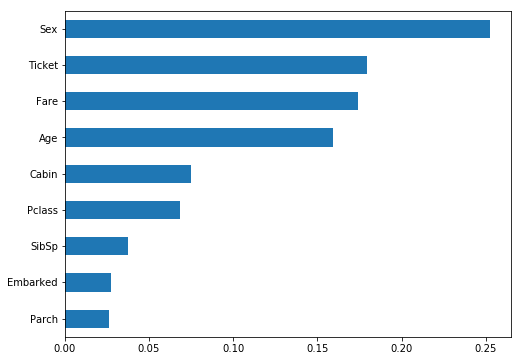

1.0


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [5]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=200, random_state=0)
model.fit(X_train, y_train)
predict_proba = model.predict_proba(X_test)[:,1]
y_predict = model.predict(X_test)

result_df = pd.DataFrame(data={'PassengerId': X_test.index, 'Survived': y_predict})
# result_df.columns = ['PassengerId', 'Survived']

# print(result_df.head(100))

plot_feature_imp(model, X_test)

print(roc_auc_score(y_predict, predict_proba))

file = open('submission_rf.csv', 'w')
file.write(result_df.to_csv(index=False))
file.close()

result_df.head()


### Predict with Logistic Regression

In [6]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression().fit(X_train, y_train)
predict_proba = model.predict_proba(X_test)[:,1]
y_predict = model.predict(X_test)

result_df = pd.DataFrame(data={'PassengerId': X_test.index, 'Survived': y_predict})

# plot_feature_imp(model, X_test)

print(roc_auc_score(y_predict, predict_proba))

result_df.head()

file = open('submission_lr.csv', 'w')
file.write(result_df.to_csv(index=False))
file.close()

1.0


### Predict with SVM

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import recall_score, precision_score
from sklearn import preprocessing

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train, random_state=0)
X_train1_index = X_train1.index
X_test1_index = X_test1.index

scaler = preprocessing.StandardScaler()
np_scaled = scaler.fit_transform(X_train1)
X_train1 = pd.DataFrame(np_scaled, columns=['Pclass', 'Sex', 'Age', 'Fare', 'Cabin'])
X_train1.set_index(X_train1_index, inplace=True)

scaler = preprocessing.StandardScaler()
np_scaled = scaler.fit_transform(X_test1)
X_test1 = pd.DataFrame(np_scaled, columns=['Pclass', 'Sex', 'Age', 'Fare', 'Cabin'])
X_test1.set_index(X_test1_index, inplace=True)

model = SVC(kernel='linear', C=0.1, probability=True).fit(X_train1, y_train1)
acc_score = model.score(X_test1, y_test1)
y_predict = model.predict(X_test1)
rec_score = recall_score(y_test1, y_predict)
prec_score = precision_score(y_test1, y_predict)

predict_proba = model.predict_proba(X_test1)[:, 1]
print(roc_auc_score(y_predict, predict_proba))

print(acc_score, rec_score, prec_score)

# C=1 0.780269058296 0.702380952381 0.710843373494

1.0
0.780269058296 0.702380952381 0.710843373494


In [52]:
X_train_index = X_train.index
X_test_index = X_test.index

scaler = preprocessing.StandardScaler()
np_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(np_scaled, columns=['Pclass', 'Sex', 'Age', 'Fare', 'Cabin'])
X_train.set_index(X_train_index, inplace=True)

scaler = preprocessing.StandardScaler()
np_scaled = scaler.fit_transform(X_test)
X_test = pd.DataFrame(np_scaled, columns=['Pclass', 'Sex', 'Age', 'Fare', 'Cabin'])
X_test.set_index(X_test_index, inplace=True)

# model = SVC(C=1000000000, gamma=0.000001, probability=True).fit(X_train, y_train)
model = SVC(kernel='linear', C=0.1, probability=True).fit(X_train, y_train)

predict_proba = model.predict_proba(X_test)[:,1]
y_predict = model.predict(X_test)

result_df = pd.DataFrame(data={'PassengerId': X_test.index, 'Survived': y_predict})

print(roc_auc_score(y_predict, predict_proba))
acc_score = model.score(X_test, y_predict)
y_predict = model.predict(X_test)

print(acc_score)

result_df.head()

# plot_feature_imp(model, X_test)

file = open('submission_svc.csv', 'w')
file.write(result_df.to_csv(index=False))
file.close()

1.0
1.0
